# Dataset preprocessing

**10m\_u\_component\_of\_wind**: Horizontal wind component, representing the east–west direction (positive = eastward, negative = westward)
**10m\_v\_component\_of\_wind**: Vertical wind component, representing the north–south direction (positive = northward, negative = southward)

These two variables are strongly correlated, and direct standardization may alter the wind direction. Therefore, during data preparation, it is better to transform them into two separate variables, **wind\_speed** and **wind\_dir**, for storage.


# Pipeline data preprocessing

In [1]:
import sys
import os, json
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import geopandas as gpd

from models import (
    random_forest,
    lightgbm,
    xgboost,
    ridge,
    mlp,
    stacking,
    neural_net,
    nn_tuning,
    knn
)
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import torch
from data.split_dataset import split_and_save
import joblib

/opt/anaconda3/envs/coastsat/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Sitename options: Madhirivaadhoo, Dhakendhoo, Funadhoo, Aidhoo, Mendhoo, Keyodhoo
sitename = 'Dhakendhoo'

# Transect type options: 'radial', 'hybrid'
transect_types = 'hybrid'

In [3]:
# If not in the root directory, change directory
if os.path.basename(os.getcwd()) == "notebook":
    os.chdir("..")
    print("Switched to:", os.getcwd())

Switched to: /Users/yyy/Documents/IRP/irp-yy1824/codes/Modelling


In [ ]:
# Split and save the dataset

split_and_save(
    # data_path=f'../Fetch_data/Model_Data_{sitename}/final_data_supplemented.csv',  # Default dataset path
    data_path='./data/final_data_supplemented_total_2016-2023_hybrid.csv',      # Customer dataset path                                             # Custom dataset path
    output_path='./Dataset/',
    test_size=0.2,
    random_state=42,
    sitename=sitename
)

Original data shape: (32741, 17)
Shape after dropping missing values: (32741, 17)
Training set shape: (26192, 14)
Test set shape: (6549, 14)
Target standardization (train-only): mu=-0.009132, sigma=0.234912
All data has been saved!
Updated μ/σ in: ../CoastSat/data/Keyodhoo/Keyodhoo_reconstruction_metadata.json


/Users/yyy/Documents/IRP/irp-yy1824/codes/Modelling/data/split_dataset.py:32: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  date_ordinal = d.view('int64') / 86_400_000_000_000  # 86400 * 1e9
/opt/anaconda3/envs/coastsat/lib/python3.13/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [5]:
X_train = joblib.load('./Dataset/X_train.pkl')
y_train = joblib.load('./Dataset/y_train.pkl')
X_test = joblib.load('./Dataset/X_test.pkl')
y_test = joblib.load('./Dataset/y_test.pkl')

# Random Forest

In [6]:
# Train and evaluate the model
model = random_forest.train_model(X_train, y_train)
random_forest.evaluate_model(model, X_test, y_test)
random_forest.save_model(model, './outputs/rf_model.pkl')

Test MSE: 0.048
Test RMSE: 0.220
Test R²: 0.951
Model saved to: ./outputs/rf_model.pkl


In [7]:
rf_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# LightGBM

In [8]:
model = lightgbm.train_model(X_train, y_train)
lightgbm.evaluate_model(model, X_test, y_test)
lightgbm.save_model(model, './outputs/lgb_model.pkl')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2891
[LightGBM] [Info] Number of data points in the train set: 26192, number of used features: 16
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [9]:
lgb_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# XGBoost

In [10]:
model = xgboost.train_model(X_train, y_train)
xgboost.evaluate_model(model, X_test, y_test)
xgboost.save_model(model, './outputs/xgb_model.pkl')

Test MSE: 0.127
Test RMSE: 0.356
Test R²: 0.871
Model saved to: ./outputs/xgb_model.pkl


In [11]:
xgb_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Ridge Regression

In [12]:
model = ridge.train_model(X_train, y_train, alpha=1.0)
ridge.evaluate_model(model, X_test, y_test)
ridge.save_model(model, './outputs/ridge_model.pkl')

Test MSE: 0.893
Test RMSE: 0.945
Test R²: 0.089
Model saved to: ./outputs/ridge_model.pkl


In [13]:
ridge_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': abs(model.coef_)
}).sort_values(by='Importance', ascending=False)

# KNN

In [14]:
model = knn.train_model(X_train, y_train, n_neighbors=7)
knn.evaluate_model(model, X_test, y_test)
knn.save_model(model, './outputs/knn_model.pkl')

Test MSE: 0.694
Test RMSE: 0.833
Test R²: 0.292
Model saved to ./outputs/knn_model.pkl


In [15]:
results = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

knn_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': results.importances_mean
}).sort_values(by='Importance', ascending=False)

# MLPRegressor

In [16]:
model = mlp.train_model(
    X_train,
    y_train,
    hidden_layer_sizes=(64, 64),
    activation='relu',
    learning_rate_init=0.001,
    max_iter=1000
)
mlp.evaluate_model(model, X_test, y_test)
mlp.save_model(model, './outputs/mlp_model.pkl')

Test MSE: 0.761
Test RMSE: 0.872
Test R²: 0.224
Model saved to: ./outputs/mlp_model.pkl


In [17]:
results = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

mlp_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': results.importances_mean
}).sort_values(by='Importance', ascending=False)

# Stacking
- LightGBM
- XGBoost
- Ridge Regression 

and use Ridge as the meta-learner.

In [18]:
model = stacking.train_model(
    X_train,
    y_train,
    ridge_alpha=0.5,
    lgb_params={'n_estimators': 300, 'learning_rate': 0.03, 'max_depth': 8, 'random_state': 42},
    xgb_params={'n_estimators': 300, 'learning_rate': 0.03, 'max_depth': 8, 'random_state': 42}
)
stacking.evaluate_model(model, X_test, y_test)
stacking.save_model(model, './outputs/stacking_model.pkl')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2891
[LightGBM] [Info] Number of data points in the train set: 26192, number of used features: 16
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2890
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Number of data points in the train set: 20954, number of used features: 16
[LightGBM] [Inf

In [19]:
results = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

stacking_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': results.importances_mean
}).sort_values(by='Importance', ascending=False)

# Neural Network

In [20]:
model = neural_net.train_model(
    X_train,
    y_train,
    hidden_dim=64,
    lr=0.001,
    epochs=200,
    batch_size=64
)
neural_net.evaluate_model(model, X_test, y_test)
neural_net.save_model(model, './outputs/neural_net_model.pth')


Test MSE: 0.145
Test RMSE: 0.380
Test R²: 0.852
Model saved to: ./outputs/neural_net_model.pth


In [21]:
from notebook.tools import permutation_importance_nn, r2_score_fn

nn_feature_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': permutation_importance_nn(model, X_test, y_test, r2_score_fn)
}).sort_values(by='Importance', ascending=False)


# Neural Network: Automatic hyperparameter tuning

In [22]:
best_params = nn_tuning.run_optuna(X_train, y_train, n_trials=30)
model = neural_net.train_model(
    X_train,
    y_train,
    hidden_dim=best_params['hidden_dim'],
    lr=best_params['lr'],
    epochs=best_params['epochs']
)
neural_net.save_model(model, './outputs/neural_net_model_tuned.pth')

[I 2025-08-25 21:15:23,683] A new study created in memory with name: no-name-6d582723-a488-44ff-96ea-1f3f727bf31b
/Users/yyy/Documents/IRP/irp-yy1824/codes/Modelling/models/nn_tuning.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
/Users/yyy/Documents/IRP/irp-yy1824/codes/Modelling/models/nn_tuning.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
[I 2025-08-25 21:16:51,146] Trial 0 finished with value: 0.3483050407003742 and parameters: {'hidden_dim': 146, 'lr': 0.007980766245022454, 'weight_decay': 0.00010031357023509493, 'epochs': 471}. Best is 

Best trial:
{'hidden_dim': 225, 'lr': 0.0009438027503204653, 'weight_decay': 4.195600618515394e-05, 'epochs': 300}
Best MSE: 0.11923909039964586
Model saved to: ./outputs/neural_net_model_tuned.pth


In [23]:
nn_tuned_feature_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': permutation_importance_nn(model, X_test, y_test, r2_score_fn)
}).sort_values(by='Importance', ascending=False)

In [24]:
with open('./outputs/nn_tuned_best_params.json', 'w') as f:
    json.dump(best_params, f)

neural_net.evaluate_model(model, X_test, y_test)

Test MSE: 0.113
Test RMSE: 0.336
Test R²: 0.885


(0.11304342850769131, np.float64(0.33621931608355177), 0.8847084440727813)

# Feature Importance

In [25]:
from notebook.tools import calculate_avg_feature_importance

feature_importance_dfs = [
    rf_feature_importance,
    lgb_feature_importance, 
    xgb_feature_importance,
    ridge_feature_importance,
    knn_feature_importance,
    mlp_feature_importance,
    stacking_feature_importance,
    nn_feature_importance,
    nn_tuned_feature_importance
]

avg_importance = pd.DataFrame(calculate_avg_feature_importance(feature_importance_dfs))
avg_importance

,Feature,Importance
0,reef_width_m,0.820738
1,reef_slope_deg,0.682851
2,reef_flat_mean_depth_m,0.606453
3,reef_crest_elevation_m,0.384786
4,slope_m_per_m,0.345267
5,island_orientation,0.273060
6,month_sin,0.096359
7,significant_height_of_combined_wind_waves_and_...,0.083418
8,month_cos,0.082678
9,NDVI,0.070775


# Prediction

### Sklearn related model prediction
Including ensemble methods (Random Forest, LightGBM, XGBoost, Stacking), a linear model (Ridge Regression), an instance-based method (K-Nearest Neighbors)

In [45]:
# Choose the evaluation dataset and model
eval_path = f'./data/final_data_supplemented_total_2024_hybrid.csv'
model_path = './outputs/mlp_model.pkl'

In [ ]:
from preprocessing.eval_trans import evaluate_on_csv

metrics, _ = evaluate_on_csv(
    eval_path=eval_path,
    model_path=model_path,
    save_pred_path=None
)
metrics


/Users/yyy/Documents/IRP/irp-yy1824/codes/Modelling/preprocessing/eval_trans2.py:35: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  date_ns = X['date'].view('int64')
/opt/anaconda3/envs/coastsat/lib/python3.13/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


{'r2': 0.17178996719212192,
 'mse': 0.04566211825045051,
 'rmse': 0.21368696322061978,
 'n': 4751}

### Pytorch model prodiction
Including neural networks (Multi-layer Perceptron Regressor, feed-forward neural networks, and auto-tuned variants). 

In [33]:
# py_eval_path = f'./data/final_data_supplemented_total_2024_{transect_types}.csv'
py_eval_path = eval_path

# model_type options: 'neural_net_model' or 'neural_net_model_tuned'
model_type = 'neural_net_model'



In [ ]:
from preprocessing.eval_trans import evaluate_neural_net_model

if __name__ == "__main__":
    metrics, predictions = evaluate_neural_net_model(
        eval_csv_path=eval_path,
        model_type=model_type
    )

Loaded feature columns: 16
Input dimension: 16
Hidden layer dimension: 64
Model loaded from: ./outputs/neural_net_model.pth

📊 Model Evaluation on Target Island:
  R² Score: -432571.0129
  Mean Squared Error (MSE): 23849.2093
  Root Mean Squared Error (RMSE): 154.4319
  Number of samples: 4751


/opt/anaconda3/envs/coastsat/lib/python3.13/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


# Visualization
For **Experiment 3**

Below is an example of a reconstruction: the coastline shape of Keyodhoo Island in 2024, rebuilt under the hybrid framework after learning from data spanning 2016–2023.


In [ ]:
from preprocessing.eval_trans import evaluate_on_csv

metrics, yhat = evaluate_on_csv(
    eval_path='data/2024_pre_example.csv',
    model_path=model_path,
    save_pred_path='data/pred_eval_output.csv'
)
print(metrics)

/Users/yyy/Documents/IRP/irp-yy1824/codes/Modelling/preprocessing/eval_trans.py:31: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  date_ns = X['date'].view('int64')
/opt/anaconda3/envs/coastsat/lib/python3.13/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


{'r2': 0.9332944308619846, 'mse': 0.01107380776534115, 'rmse': 0.10523216126898255, 'n': 11}


[saved] ./figs/Keyodhoo_2024-12-11_pred-vs-true_tidalcorr.png  (dpi=300)
[saved] ./figs/Keyodhoo_2024-12-11_pred-vs-true_tidalcorr.pdf  (dpi=300)


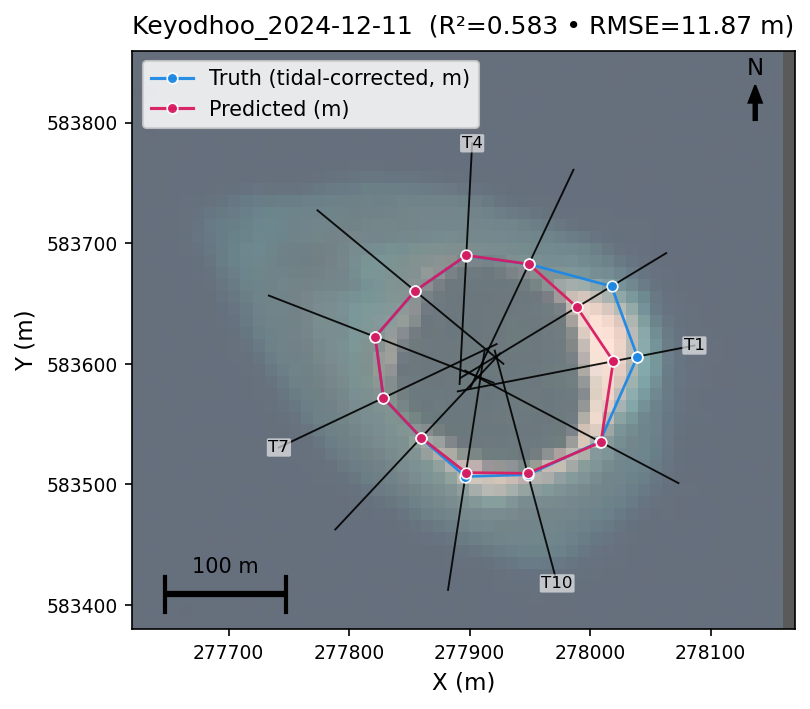

In [ ]:
from notebook.pre_plot import quick_plot_using_tidal_truth

quick_plot_using_tidal_truth(
    tidal_csv="./example/Keyodhoo_transect_time_series_tidally_corrected_example.csv",
    transects_geojson="./example/Keyodhoo_hybrid_transects.geojson",
    raster_path="./example/2024-12-11-05-37-43_S2_43NBF_Keyodhoo_ms.tif",
    meta_json="./example/Keyodhoo_reconstruction_metadata.json",
    date_str="2024-12-11",
    pred_eval_csv="data/pred_eval_output_with_transect.csv",  
    show_transect_names_every=3,
    close_ring=True,
    save_path=None,
    save_dpi=300
)